In [11]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras.layers import LeakyReLU
from keras.regularizers import l2
import math

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
train_dir = '/content/drive/MyDrive/Gabor_cropped_Final/Train'
test_dir = '/content/drive/MyDrive/Gabor_cropped_Final/Test'

# Image Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Load the images from the specified directory
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(524, 524),
    batch_size=32,
    class_mode='binary',
    color_mode='grayscale' # since the images are grayscale
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(524, 524),
    batch_size=32,
    class_mode='binary',
    color_mode='grayscale', # since the images are grayscale
    shuffle=False
)

Found 1080 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


In [14]:
#  Learning Rate Adjustment:
def step_decay(epoch):
    initial_rate = 0.001
    drop = 0.5
    epochs_drop = 10.0
    new_rate = initial_rate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return new_rate

rate_scheduler = LearningRateScheduler(step_decay)


In [13]:
# Model Architecture
def create_model(input_shape):
    inputs = Input(shape=input_shape)

    # Conv2D with 48 filters of size 11x11
    x = Conv2D(48, (11, 11))(inputs)
    x = LeakyReLU(alpha=0.1)(x) # LeakyReLU activation
    x = BatchNormalization()(x)
    x = MaxPooling2D((3, 3))(x)
    x = Dropout(0.4)(x)

    # Conv2D with 96 filters of size 5x5
    x = Conv2D(96, (5, 5))(x)
    x = LeakyReLU(alpha=0.1)(x) # LeakyReLU activation
    x = BatchNormalization()(x)
    x = MaxPooling2D((3, 3))(x)
    x = Dropout(0.4)(x)

    # Additional Conv2D layer with 128 filters of size 3x3
    x = Conv2D(128, (3, 3))(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((3, 3))(x)
    x = Dropout(0.4)(x)

    # Flatten the tensor
    x = Flatten()(x)

    # Fully Connected Layer with 1024 units and L2 regularization
    x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.4)(x)

    # Output Layer for Binary Classification
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [15]:
# Create the model with the specified input shape
model = create_model((524, 524, 1))

# Compile the model with RMSprop optimizer
optimizer = RMSprop(learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping, learning rate scheduler, and other callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_delta=0.0001)
callbacks_list = [early_stop, reduce_lr, rate_scheduler]

# Train the model
epochs = 50
batch_size = 32
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator,
    callbacks=callbacks_list,
    batch_size=batch_size
)

#callback helped to get both accuracy

Epoch 1/50
34/34 [==============================] - 28s 685ms/step - loss: 48.7362 - accuracy: 0.5009 - val_loss: 15.5282 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/50
34/34 [==============================] - 22s 634ms/step - loss: 8.9323 - accuracy: 0.5676 - val_loss: 7.9204 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/50
34/34 [==============================] - 22s 641ms/step - loss: 3.8844 - accuracy: 0.5620 - val_loss: 3.0435 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/50
34/34 [==============================] - 22s 633ms/step - loss: 7.7163 - accuracy: 0.5343 - val_loss: 34.8987 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 5/50
34/34 [==============================] - 22s 636ms/step - loss: 2.1104 - accuracy: 0.5833 - val_loss: 11.8885 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 6/50
34/34 [==============================] - 22s 641ms/step - loss: 2.7983 - accuracy: 0.5500 - val_loss: 8.2156 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 7/50
34/34 [==============================] - 22s 640m

In [16]:
# Evaluate the model on the test dataset
loss, accuracy = model.evaluate(test_generator)

# Print the results
print(f"Accuracy: {accuracy:.4f}")


2/2 [==============================] - 0s 115ms/step - loss: 0.5270 - accuracy: 0.8500
Accuracy: 0.8500


In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
# Predict class labels for the test dataset
predictions = model.predict(test_generator)
y_pred = np.round(predictions).astype(int).flatten()

# Get the true class labels
y_true = test_generator.classes

# Calculate precision, recall, and F1-score
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Print the results
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")


2/2 [==============================] - 0s 101ms/step
Precision: 0.9200
Recall: 0.7667
F1-score: 0.8364


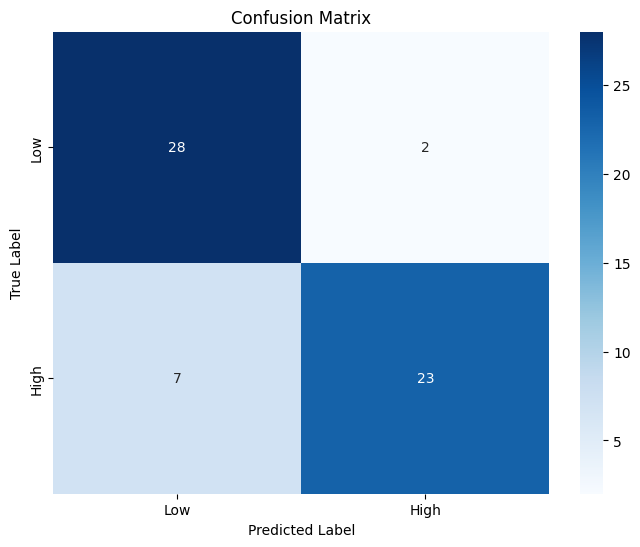

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

2/2 [==============================] - 0s 110ms/step


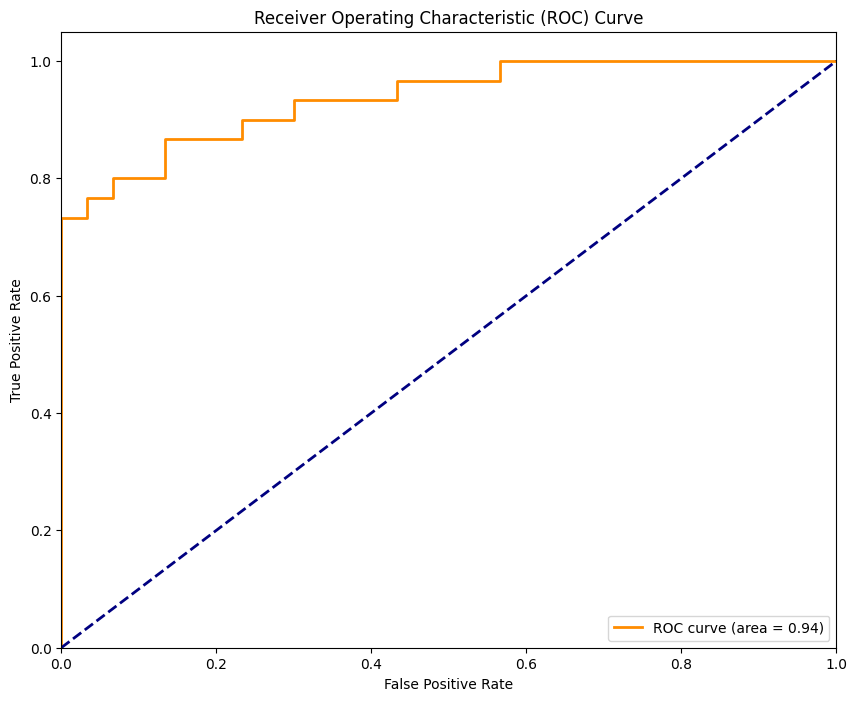

In [19]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predict class probabilities for the test dataset
predictions = model.predict(test_generator)

# Get the true class labels
y_true = test_generator.classes

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_true, predictions)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()